In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from scipy.special import jv, kv
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


In [7]:
# import mc data file
# mcfile = 'mc_data/mc_data_trial4.npy'
mcfile = 'test_2-7-2025.npy'
mcdata = np.load(mcfile)
mc_df = pd.DataFrame(mcdata, columns=['s', 'Q', 'x', 'delta', 'pT', 'z', 'y', 'phi_kp', 'phi_Dp', 'dsa', 'unxsec'])


In [9]:
mc_df

,s,Q,x,delta,pT,z,y,phi_kp,phi_Dp,dsa,unxsec
0,10000.0,8.662537,0.007871,0.447945,6.533812,0.649727,0.953314,3.508238,4.584885,-2.890269e-15,3.835273e-18
1,10000.0,8.099343,0.008178,0.245867,4.251722,0.320903,0.802193,3.402627,0.512017,-4.723707e-14,5.794977e-17
2,10000.0,7.119468,0.007909,0.700431,5.747168,0.747518,0.640880,5.979262,1.001361,-1.428962e-14,1.727639e-17
3,10000.0,7.326347,0.005645,0.256775,1.684584,0.264932,0.950924,5.696662,2.123399,-8.465406e-13,1.017542e-15
4,10000.0,8.844288,0.009270,0.514822,7.671754,0.432147,0.843800,3.577267,1.780531,-8.727142e-16,1.547596e-18
...,...,...,...,...,...,...,...,...,...,...,...
9995,10000.0,6.561265,0.009428,0.280387,6.591424,0.539042,0.456620,2.813646,0.055744,-3.593193e-15,1.399276e-17
9996,10000.0,6.999691,0.007097,0.353315,2.785734,0.623692,0.690331,3.236447,1.478059,-3.814534e-13,7.119550e-16
9997,10000.0,7.598255,0.007475,0.574031,5.817317,0.246684,0.772342,4.977256,1.234706,-1.063794e-14,5.769492e-18
9998,10000.0,8.465041,0.007971,0.358066,9.480682,0.837262,0.898955,5.065663,0.315019,-6.931481e-17,1.397408e-19


In [11]:
# function to plot histograms

def plot_histogram(df, plot_q, constraints, vary_q=None, **options):

    fig, (ax, ax_info) = plt.subplots(1, 2, figsize=(12, 6), gridspec_kw={'width_ratios': [5, 1]})

    # make bins
    range = [df[plot_q].min(), df[plot_q].max()]
    nbins = options.get('nbins', 10)
    bin_width = options.get('binwidth', (range[1] - range[0])/nbins)
    bins = np.arange(np.floor(range[0]/bin_width)*bin_width, np.ceil(range[1]/bin_width)*bin_width, bin_width)
    # print(bins)

    # enforce constraints
    mask = pd.Series(True, index=df.index)
    for var, (low, high) in constraints.items(): mask &= df[var].between(low, high)
    fixed_df = df[mask]



    # make plot data
    if vary_q:
        var, values = list(vary_q.items())[0]
        for value in values:
            vfixed_df = fixed_df[fixed_df[var].between(value*0.99, value*1.01)] # default here is requested value is within 1%
            
            # counts, plot_bins = np.histogram(vfixed_df[plot_q], bins=bins, weights=vfixed_df['dsa'])
            counts, plot_bins = np.histogram(vfixed_df[plot_q], bins=bins)
            bin_centers = 0.5*(plot_bins[:-1]+plot_bins[1:])
            bin_widths = 0.5*(plot_bins[1:]-plot_bins[:-1])
            errors = np.sqrt(counts) # poisson error
            
            ax.errorbar(
                bin_centers, counts, yerr=errors, xerr=bin_widths,
                fmt=options.get('fmt', 'o'), label=options.get('label', fr'${var} = {value}\pm{value*0.01}$'), capsize=3, elinewidth=1, capthick=1
            )
        ax.legend()
            
    else: 
        # counts, plot_bins = np.histogram(fixed_df[plot_q], bins=bins, weights=fixed_df['dsa'])
        counts, plot_bins = np.histogram(fixed_df[plot_q], bins=bins)
        bin_centers = 0.5*(plot_bins[:-1]+plot_bins[1:])
        bin_widths = 0.5*(plot_bins[1:]-plot_bins[:-1])
        errors = np.sqrt(counts) # poisson error
        
        ax.errorbar(
            bin_centers, counts, yerr=errors, xerr=bin_widths,
            fmt=options.get('fmt', 'o'), label=options.get('label', ''), capsize=3, elinewidth=1, capthick=1
        )

    # make info box for constraints
    info_text = 'Constraints:\n'
    for var, (low, high) in constraints.items():
        info_text += fr'${var}: [{low}, {high}]$'+'\n'
    ax_info.text(
        -0.3, 0.85, info_text, 
        ha='left', va='bottom', 
        fontsize=12, wrap=True, 
        bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.3)
    )
    ax_info.set_axis_off()

    # set plot info
    if options.get('y_limits'): ax.set_ylim(options.get('y_limits'))
    if options.get('x_limits'): ax.set_ylim(options.get('x_limits'))
    ax.set_title(options.get('title', f'{plot_q} frequency'))
    ax.set_ylabel(options.get('y_label', 'Frequency'))
    ax.set_xlabel(options.get('x_label', fr'${plot_q}$'))
    ax.set_yscale(options.get('y_scale', 'linear'))
    ax.set_xscale(options.get('x_scale', 'linear'))
    ax.grid(options.get('grid', True)) 



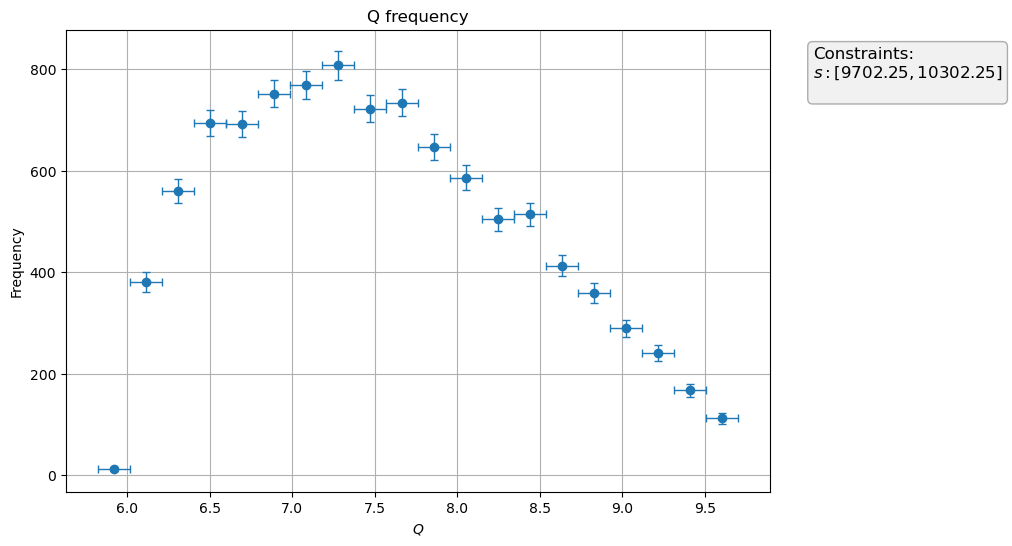

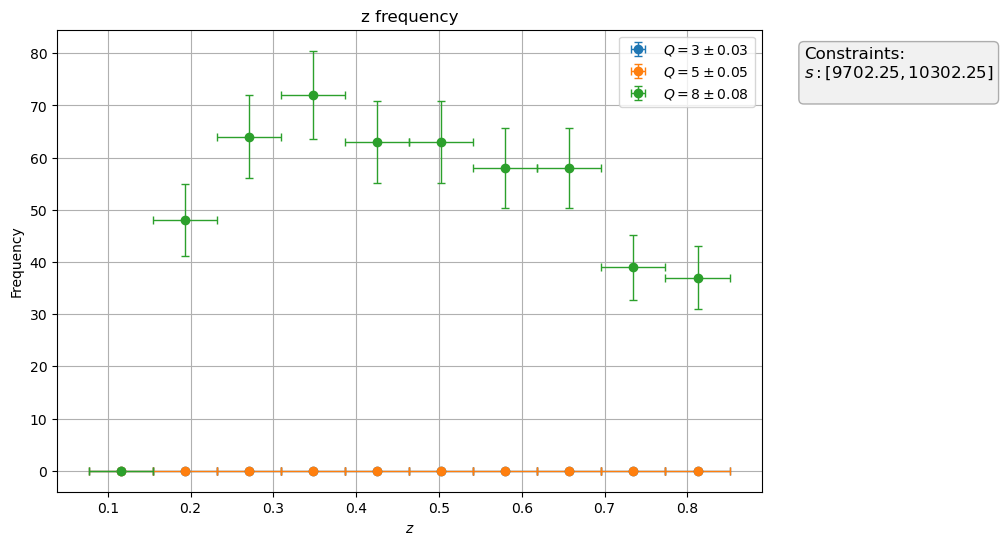

In [15]:
plot_s = 100
delta_s = 1.5

# plot_histogram(mc_df, 'Q', {'s': [(plot_s-delta_s)**2, (plot_s+delta_s)**2], 'y':[0.1, 0.9]}, vary_q={'z': [0.2, 0.3, 0.4, 0.5]})
plot_histogram(mc_df, 'Q', {'s': [(plot_s-delta_s)**2, (plot_s+delta_s)**2]}, nbins=20)
plot_histogram(mc_df, 'z', {'s': [(plot_s-delta_s)**2, (plot_s+delta_s)**2]}, vary_q={'Q': [3, 5, 8]})

# plot_histogram(mc_df, 'phi_kp', {'s': [(plot_s-delta_s)**2, (plot_s+delta_s)**2]}, vary_q={'Q': [8]}, nbins=10)



